<img src='http://sn.nexteinstein.org/wp-content/uploads/sites/12/2016/07/aims_senegal.jpg' />

In this notebook you will implement and train a feed-forward neural network using the torch.nn module to solve a multi-class classification problem on a dataset called "Fashion MNIST".

---

***Learning Objectives:***

* Understand how to use Pytorch nn module and the sequential container to build a neural network architecture.


* Understand how a model is trained using the opitm module and the Autgrad engine and How to evaluate your model.

---

**Resources that you need to cover before starting**:

* Review the Tutorial Notebook.

* Read the torch.nn docs: https://pytorch.org/docs/stable/nn.html

* Read the article about moving from computing gradient from scratch to useing torch.nn https://pytorch.org/tutorials/beginner/nn_tutorial.html

* Read the pytorch offical tutorial on training multi-class classifiers:
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# Setup code (Read first But Don't modify)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
%matplotlib inline



---



#### Loading the Data: 

We will use the Fashion MNIST dataset consisting of 70,000 greyscale images of shape(28x28 flattened to have shape 784) and their labels.

The dataset is divided into 60,000 training images and 10,000 test images. The idea is to train a classifier to identify the class value (what type of fashion item it is) given the image (total of **10** classes).

We will split the training data into 50,000 training images used to train a model on it, and 10,000 validation images used to tune your choice of hyperparams and model architecture.

The last step is to evaluate how well your model classifies the 10,000 test images (will be used to assess your implementation).


**The classes are: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']**

This is how the 10 class images looks like before flattening it:

<img src='https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F549262%2Fd6f4f6e13fa211c9e773479566d89ac9%2FExample-for-fashion-MNIST-Each-class-is-represented-by-nine-cases.png?generation=1576784453715625&alt=media' />



---



In [ ]:
#get the data

def load_data():

  #using the dataset module from torchvision
  mnist_train_set = datasets.FashionMNIST('data/fashiomnist/', train = True, download = True)
  mnist_test_set = datasets.FashionMNIST('data/fashiomnist/', train = False, download = True)

  #train data
  train_images = mnist_train_set.data.view(-1, 1, 28, 28).float()
  train_targets = mnist_train_set.targets

  #test data
  test_images = mnist_test_set.data.view(-1, 1, 28, 28).float()
  y_test = mnist_test_set.targets

  #flatten
  train_val_input = train_images.clone().reshape(train_images.size(0), -1)/255.0
  x_test = test_images.clone().reshape(test_images.size(0), -1)/255.0

  # shuffle
  N = train_val_input.shape[0]
  index = torch.randperm(N)
  #train val split
  x_train = train_val_input[index][:50000]
  y_train = train_targets[index][:50000]

  x_val = train_val_input[index][50000:]
  y_val = train_targets[index][50000:]

  return x_train, y_train, x_val, y_val, x_test, y_test

In [ ]:
x_train, y_train, x_val, y_val, _, __ = load_data()


Extracting data/fashiomnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/fashiomnist/FashionMNIST/raw



Extracting data/fashiomnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/fashiomnist/FashionMNIST/raw



Extracting data/fashiomnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/fashiomnist/FashionMNIST/raw



Extracting data/fashiomnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/fashiomnist/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
print('train data shape: ', x_train.shape)
print('train targets shape: ', y_train.shape)
print(' ')
print('validation data shape: ', x_val.shape)
print('Validation targets shape: ', y_val.shape)

train data shape:  torch.Size([50000, 784])
train targets shape:  torch.Size([50000])
 
validation data shape:  torch.Size([10000, 784])
Validation targets shape:  torch.Size([10000])




---



---



#### We will be using gpus to accelerate the training. make sure to change your runtime to use a *gpu*.

#### go to Runtime ===> Change Runtime Type ===> Hardware accelerator ===> choose (GPU)


In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')
  
print('using device:', device)

using device: cuda:0


Note that every tensor in pytorch has a **.device** attribute By default it's set to 'cpu' But it can be changed to 'gpu' using the **'.to'** command:

In [ ]:
# toy example 
a = torch.rand(2,3)
print(a.device) # by default it's 'cpu'

a = a.to(device = device)
print(a.device) # should print 'cuda:0'

cpu
cuda:0


---
---
---
---
---

Now it's your turn to define a model using the **torch.nn.Sequential** container module.

Your model should accept an input of shape D = 784 and output 10 numbers represent the probability of belonging to each class.

ideally a good model will have at least one hidden layer (or more) followed by non-linear activation functions like (nn.ReLU, nn.Sigmoid ... etc) 


you can take some help from the docs: 
https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html 

In [ ]:
# define a neural network model using the nn.Sequential container

D = x_train.shape[1]
n_classes = 10
h1, h2,h3= 200,100,50
# model = nn.Sequential(
#           nn.Conv2d(D,28,28),
#           nn.ReLU(),
#           nn.Conv2d(10),
#           nn.ReLU()
    
#     #your code should be here  

# )

model= nn.Sequential(
    nn.Linear(D,h1),
    nn.ReLU(),

    nn.Linear(h1,h2),
    nn.ReLU(),
    nn.Linear(h2,h3),
    nn.ReLU(),

    nn.Linear(h3, n_classes),
    
)

In [ ]:
print(model) #Run this when you finish defining your model

Sequential(
  (0): Linear(in_features=784, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=50, bias=True)
  (5): ReLU()
  (6): Linear(in_features=50, out_features=10, bias=True)
)


In [ ]:
#Run This cell
# it's important to transfer your model to the gpu for faster computations

model = model.to(device=device)



---


---



---




---



---



Now that we have our model and data ready, we need to train it: 

But in order to do that we need to define our loss function:

luckly pytorch has most loss functions already implemented, for multi-class classification problems, we will be using the cross entroy loss which is basically computing the log softmax of an input followed by computing the negative log liklihood loss.

read this for more info on the cross entropy loss: https://en.wikipedia.org/wiki/Cross_entropy

also check the pytorch definition of it: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html (**important**)

In [ ]:
#run this cell

criterion = nn.CrossEntropyLoss()



---



---





---



---



---



Another important step in training any model is to update it's weights and biases, and for that we need an optimization algorithm like Gradient decsent, Luckily in pytorch most optimization algorithms are implemented in the torch.optim module, and for this assignment we will be using the optim.SGD But you are free to look into more optim in the doc: https://pytorch.org/docs/stable/optim.html.

You need to find suitable values for the learning rate and the momentum value

In [ ]:
learning_rate = 0.0001   # to be set
momentum_value =  0.9   # to be set

optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum_value)




---



---



---


---



---



# Now that we have all things set, let's train our model using Automatic differentaition from pytorch. 

In [ ]:
batch_size = 32       #set your batch size 

In [ ]:
#Run this cell 
# it wil set the number of batches for mini batch SGD

N = x_train.shape[0]

if N % batch_size == 0:
  n_batches = int(N / batch_size)
else:
  n_batches = int(N / batch_size) + 1



---

---



---



---





# Main Training loop
### ToDo: fill in the missing steps


In [ ]:
n_epochs = 100  # set the number of epochs
losses = []

for epoch in range(n_epochs):
  
  epoch_loss = 0
  
  for batch in range(n_batches):
    
    start = batch * batch_size
    end = start + batch_size

    train_images = x_train[start:end]
    train_labels = y_train[start:end]

    train_images = train_images.to(device= device)       # change the device of train_images to gpu
    train_labels = train_labels.to(device= device)       # change the device of train_labels to gpu

    outputs = model(train_images)      # feed the images totrain_labels the model to get the outputs

    loss = criterion(outputs, train_labels)        # compute the loss using the criterion we defined
    
    epoch_loss += loss.item()
    
    loss.backward()
    # zero the grad
    optimizer.step()
    # compute the gradient for each weight/bias from the loss
    
    # update the model parameters
    
    optimizer.zero_grad()
  epoch_loss = epoch_loss/N

  print('epoch ==> ', epoch, 'loss ==> ', epoch_loss)

  losses.append(epoch_loss)

epoch ==>  0 loss ==>  0.07150523717880249
epoch ==>  1 loss ==>  0.06972428874969483
epoch ==>  2 loss ==>  0.06452390689134598
epoch ==>  3 loss ==>  0.05287180903196335
epoch ==>  4 loss ==>  0.04200929523229599
epoch ==>  5 loss ==>  0.03618293467402458
epoch ==>  6 loss ==>  0.03246610339641571
epoch ==>  7 loss ==>  0.029668017748594285
epoch ==>  8 loss ==>  0.027609781430959702
epoch ==>  9 loss ==>  0.026129707297086715
epoch ==>  10 loss ==>  0.02492981540441513
epoch ==>  11 loss ==>  0.02384250281870365
epoch ==>  12 loss ==>  0.022820404042601584
epoch ==>  13 loss ==>  0.02188832062125206
epoch ==>  14 loss ==>  0.021076398482322692
epoch ==>  15 loss ==>  0.020380893620848654
epoch ==>  16 loss ==>  0.0197808282661438
epoch ==>  17 loss ==>  0.019256148907244204
epoch ==>  18 loss ==>  0.018792005564272404
epoch ==>  19 loss ==>  0.018376923999488353
epoch ==>  20 loss ==>  0.0180033036968112
epoch ==>  21 loss ==>  0.017664329188466072
epoch ==>  22 loss ==>  0.01735506

## ToDo: use matplot lib to plot the loss

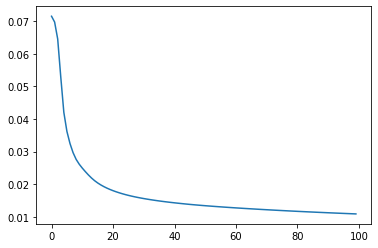

In [ ]:
# Your code should ne here
plt.plot(losses)




---



---



---


---



---



Now that we have trained our model, we need to know how much this model will perform (in term of accuracy) on the validation set.

The performance on the validation set should give us a good hint, on how well our model will perform on the test set.



In [ ]:
# Run this cell

BS = 256 
N_val = x_val.shape[0]

if N_val % BS == 0:
  n_batches = int(N_val / BS)
else:
  n_batches = int(N_val / BS) + 1

#### ToDo: fill in the missing lines to compute the accuracy on the test set.

In [ ]:
correct = 0
total = 0
# Add the no grad context manager (covered in the tutorial)
with torch.no_grad():  
  for batch in range(n_batches):
    start = batch * BS
    end = start + BS
    val_images = x_val[start:end]
    val_labels = y_val[start:end]
    val_images =   val_images.to(device= device)      # change the device of val_images to gpu
    val_labels =   val_labels.to(device=device)     # change the device of val_labels to gpu
    outputs =  model(val_images)
              # feed the val_images to the model to get the outputs
    _,predicted = torch.max(outputs,1)       # compute the argmax of the outputs to get the predicted labels
        
    total += val_labels.size(0)
        
    correct += (predicted == val_labels).sum().item()

  print('Accuracy of the network on the %d test images: %d %%' % (
    total, 100 * correct / total))


Accuracy of the network on the 10000 test images: 86 %


# You are expected to get good val acc > 70% at least



---



---



---

